In [2]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display

import tensorflow as tf
import keras
from keras import layers

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r'D:\L_IACD\SoundClassification\ML2-Project\UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


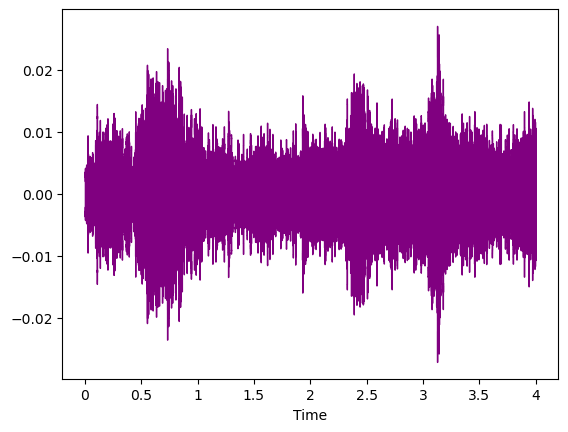

In [4]:
sample_num = 1 #pick a file to display
filename = df.slice_file_name[sample_num] #get the filename

tstart = df.start[sample_num] #define the beginning time of the signal
tend = df.end[sample_num] #define the end time of the signal

#'D:\L_IACD\SoundClassification\UrbanSound8K\audio\fold5\100263-2-0-126.wav'

path = '../UrbanSound8K/audio/fold' + str(df.fold[sample_num]) + '/' + str(filename)

y, sr = librosa.load(path)
librosa.display.waveshow(y,sr=sr, x_axis='time', color='purple', offset=0.0)

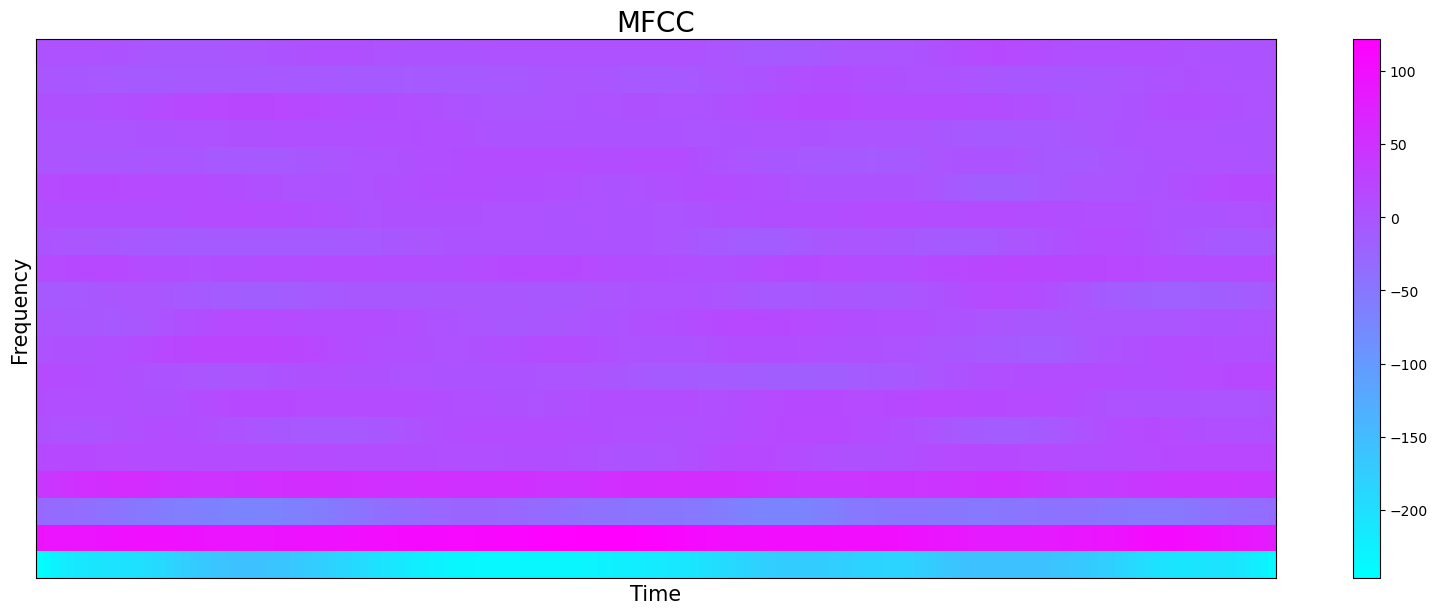

In [5]:
hop_length = round(44100 * 0.0125)
n_fft = 2**14 #number of samples 
hop_length = round(44100 * 0.0125)
MFCCs = librosa.feature.mfcc(y = y, n_fft = n_fft, hop_length = hop_length, n_mfcc = 20)
    
fig, ax = plt.subplots(figsize = (20,7))
librosa.display.specshow(MFCCs, sr=sr, cmap='cool', hop_length = hop_length)
ax.set_xlabel('Time', fontsize = 15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_title('MFCC', size = 20)
plt.colorbar()
plt.show()

In [6]:
def zero_padded_data_nparray(audios_path, duration_secs=4, target_sample_rate=44100, files_limit=-1, verbose=False):
    files = librosa.util.find_files(audios_path)
    data_array = []

    for index, file in enumerate(files):
        if files_limit != -1 and index >= files_limit: break
        
        if verbose:
            print(f"At audio {index+1}/{len(files)}")
             
        signal, sample_rate = librosa.load(file, sr = None)
        
        # resample the sample rate to the target value of SR
        signal = librosa.resample(signal, orig_sr=sample_rate, target_sr=target_sample_rate)
        
        # zero padding
        if len(signal) < duration_secs*target_sample_rate:
            signal = np.concatenate([
                signal,
                np.zeros(shape=(duration_secs*target_sample_rate-len(signal), ))
            ])

        path = file.split("\\")
        newrow = [path[-1], signal]
        data_array.append(newrow)
        
    return data_array

In [7]:
def mfcc_data_nparray(audios_data, n_mfcc=20, target_sample_rate=44100, verbose=False):
    # MFCC parameters
    hop_length=round(target_sample_rate*0.0125)
    win_length=round(target_sample_rate*0.023)
    n_fft=2**14
    time_size = 4*target_sample_rate//hop_length+1
    
    # compute the MFCCs
    data_mfcc = np.zeros(shape=(len(audios_data[1]), n_mfcc, time_size))
    for index, audio_data in enumerate(audios_data[1]):
        if verbose:
            print(f"At audio {index+1}/{len(audios_data)}")
        signal_mfcc = librosa.feature.mfcc(y=audio_data, sr=target_sample_rate, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mfcc=n_mfcc)
        data_mfcc[index] = signal_mfcc


    return data_mfcc

In [8]:
def get_features(df_in, audio):
    features = [] # list to save features
    labels = [] # list to save labels

    for index in range(len(audio)):
        # get the filename        
        filename = audio[index][0]

        # find correspondig row in df_in
        row = df_in.loc[df_in["slice_file_name"] == filename]

        # get fold
        fold = row['fold']

        #save labels
        label = row['classID'] 
      
        hop_length = round(44100 * 0.0125)
        n_fft = 2**14 #number of samples 
        data = np.array([librosa.feature.mfcc(y = audio[index][1], n_fft = n_fft, hop_length = hop_length, n_mfcc = 128)], fold)
        
        features.append(data)
        labels.append(label)

    output = np.concatenate(features, axis = 0)
    return(np.array(output), labels)


In [9]:
fold_path = "../UrbanSound8K/audio/fold1/"
audio = zero_padded_data_nparray(fold_path)

X,y = get_features(df, audio)

In [10]:
# Normalizeing data
X = np.array((X-np.min(X))/(np.max(X)-np.min(X)))
X = X/np.std(X)
y = np.array(y)

In [11]:
#Split twice to get the validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 123)

#Print the shapes
X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

((558, 128, 321), (175, 128, 321), (140, 128, 321), 558, 175, 140)

### Building the RNN


#### Adding Layers

In [21]:
input_shape = (128,321)

model = keras.Sequential()

model.add(layers.LSTM(128, input_shape=input_shape))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(48, activation = 'relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               230400    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 48)                3120      
                                                                 
 dropout_5 (Dropout)         (None, 48)               

#### Compole the Model

The **Adam** optimizer manages the learning rate for stochastic gradient descent. The loss function is **SparseCategoricalCrossentropy**, which is used when each sample belongs to one label, as opposed to more than one, and it’s not binary classification. 

In [22]:
model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['acc'])

#### Fit the Model

In [29]:
a = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_val, y_val), shuffle=False)

Epoch 1/50
56/56 [==============================] - 6s 107ms/step - loss: 2.2415 - acc: 0.1505 - val_loss: 2.2946 - val_acc: 0.0929
Epoch 2/50
56/56 [==============================] - 6s 103ms/step - loss: 2.2426 - acc: 0.1470 - val_loss: 2.2922 - val_acc: 0.0929
Epoch 3/50
56/56 [==============================] - 6s 103ms/step - loss: 2.2365 - acc: 0.1505 - val_loss: 2.2934 - val_acc: 0.0929
Epoch 4/50
56/56 [==============================] - 6s 102ms/step - loss: 2.2353 - acc: 0.1452 - val_loss: 2.3026 - val_acc: 0.0929
Epoch 5/50
56/56 [==============================] - 6s 99ms/step - loss: 2.2404 - acc: 0.1344 - val_loss: 2.2926 - val_acc: 0.0929
Epoch 6/50
56/56 [==============================] - 6s 100ms/step - loss: 2.2434 - acc: 0.1344 - val_loss: 2.2976 - val_acc: 0.0929
Epoch 7/50
56/56 [==============================] - 6s 106ms/step - loss: 2.2361 - acc: 0.1487 - val_loss: 2.3051 - val_acc: 0.0929
Epoch 8/50
56/56 [==============================] - 6s 104ms/step - loss: 2.2

In [17]:
input_shape=(128,321)

model = tf.keras.Sequential()
model.add(layers.LSTM( 20,input_shape=input_shape))
model.add(layers.Dense(24, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20)                27360     
                                                                 
 dense_5 (Dense)             (None, 24)                504       
                                                                 
Total params: 27,864
Trainable params: 27,864
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_val, y_val), shuffle=False)

Epoch 1/50
8/8 [==============================] - 6s 269ms/step - loss: 2.7489 - acc: 0.1487 - val_loss: 2.7836 - val_acc: 0.0929
Epoch 2/50
8/8 [==============================] - 1s 83ms/step - loss: 2.7050 - acc: 0.1487 - val_loss: 2.7431 - val_acc: 0.0929
Epoch 3/50
8/8 [==============================] - 1s 86ms/step - loss: 2.6650 - acc: 0.1487 - val_loss: 2.7059 - val_acc: 0.0929
Epoch 4/50
8/8 [==============================] - 1s 87ms/step - loss: 2.6285 - acc: 0.1487 - val_loss: 2.6721 - val_acc: 0.0929
Epoch 5/50
8/8 [==============================] - 1s 88ms/step - loss: 2.5953 - acc: 0.1487 - val_loss: 2.6414 - val_acc: 0.0929
Epoch 6/50
8/8 [==============================] - 1s 89ms/step - loss: 2.5653 - acc: 0.1487 - val_loss: 2.6137 - val_acc: 0.0929
Epoch 7/50
8/8 [==============================] - 1s 86ms/step - loss: 2.5383 - acc: 0.1487 - val_loss: 2.5888 - val_acc: 0.0929
Epoch 8/50
8/8 [==============================] - 1s 87ms/step - loss: 2.5140 - acc: 0.1487 - va

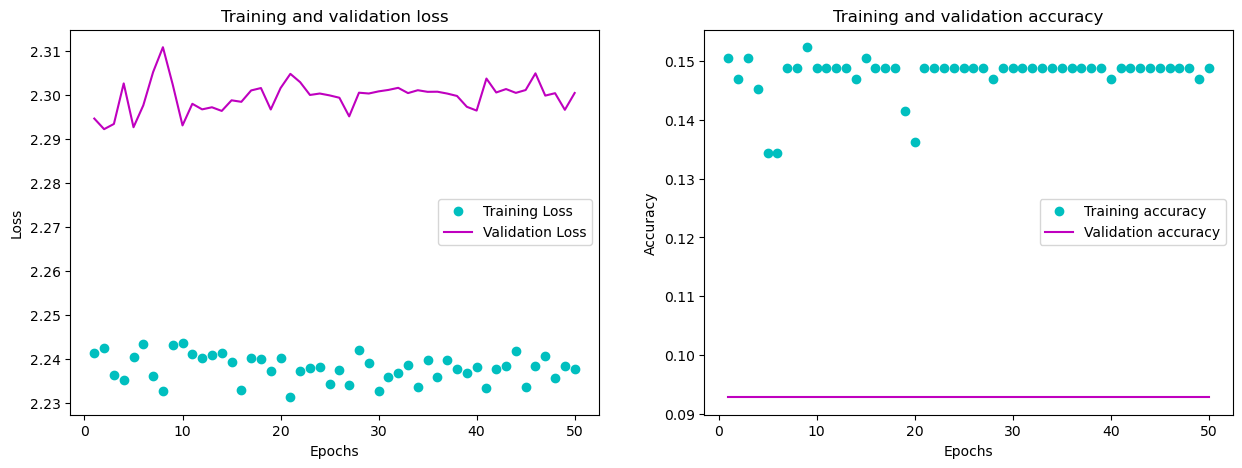

In [30]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict = a.history

loss_values=history_dict['loss']
acc_values=history_dict['acc']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_acc']
epochs = range(1,51)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()